## 0. Imports, Constants, Example Dataset

In [52]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re
from tqdm import tqdm
import copy
import json
orig_stdout = sys.stdout

# Plotting needs
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from plotly import graph_objs as go
from plotly.subplots import make_subplots

#Stat needs
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

# Set lartpc_mlreco3d path
SPINE_PATH = "/sdf/data/neutrino/software/spine/"
sys.path.append(SPINE_PATH)

# SPINE functions
from spine.driver import Driver
from spine.utils.globals import *
from spine.vis.layout import layout3d, HIGH_CONTRAST_COLORS
from spine.vis import scatter_points, scatter_particles, detector_traces
from spine.utils.geo import Geometry
from spine.data.batch import TensorBatch

In [53]:
#Physics constants
VDRIFT = 1.563 #drift velocity in SBND [mm/us]

#Config
make_plots = False
save_plots = False
DATA_PATH = '/sdf/data/neutrino/sbnd/simulation/mpvmpr_v01/spacepoint_params'
cfg = 'supera.cfg'
EVENT_ID = 1 #only two events, so choose between 0 or 1 (:

#SBND geometry
detector = Geometry('sbnd').detector.T

#Parameters for classifying a Cluster3D point as a non-ghost point using truth information (more info in 1.2.4)
sbnd_nominal_params = {
    'ne': 175,    #number of electrons
    'tw': 5,      #tick window 
    'pa': 0.425,  #post averaging threshold (cm)
    'vd': 1       #voxel distance threshold = tw/5 (voxels)
}

### 0.1 Functions

In [54]:
def get_larcv_fname(params):
    """
    Docstring generated using AI. 
    
    Generate a filename for larcv based on given parameters.
    
    Parameters
    ----------
    params : dict
        A dictionary containing the parameters for generating the filename.
        Expected keys are:
        - 'ne': str or float
        - 'pa': str or float
        - 'tw': str or float
        - 'vd': str or float
    
    Returns
    -------
    str
        Filename in the format 'larcv_ne{ne}_pa{pa}_tw{tw}_vd{vd}.root'.
    """
    return f"larcv_ne{params['ne']}_pa{int(params['pa']*1e3)}_tw{params['tw']}_vd{params['vd']}.root" 
def extract_larcv_params(fname):
    """
    Extracts the parameters from a filename generated by get_larcv_fname function.
    
    Parameters
    ----------
    fname : str
        The filename to extract parameters from.
    
    Returns
    -------
    dict
        A dictionary containing the extracted parameters from the filename.
        Keys:
        - 'ne': float
        - 'pa': float
        - 'tw': float
        - 'vd': float
    """
    # Define the pattern to extract parameters from the filename
    pattern = r'larcv_ne(\w+)_pa(\w+)_tw(\w+)_vd(\w+)\.root'

    # Use re.search to find the parameters in the filename
    match = re.search(pattern, fname)

    # Extract the parameters into a dictionary if a match is found
    if match:
        params = {
            'ne': float(match.group(1)),
            'pa': float(match.group(2))*1e-3,
            'tw': float(match.group(3)),
            'vd': float(match.group(4))
        }
        return params
    else:
        return None
def prepare_event(event,detector_coords=True):
    """
    Convert to detector coordinates (or pixel coords if false)
    """
    meta = event['meta'][0] #assume same bounding box
    event['input_data'].to_cm(meta)
    event['cluster_label'].to_cm(meta)
    event['sed'].to_cm(meta)
    event['particles_label'].to_cm(meta)
    return event

### 0.2 SBND MPVMPR simulation using nominal spacepoint parameters (see 3.5 for more info)

In [55]:
fname = get_larcv_fname(sbnd_nominal_params)
_cfg = yaml.safe_load(open(cfg, 'r').read().replace('FNAME', f'{DATA_PATH}/{fname}')\
                      .replace('EVENT_ID',str(EVENT_ID))) #load event specified

# prepare function configures necessary "handlers"
driver = Driver(_cfg)

#Parse data
event_nominal = driver.process()

#Copy and convert to detector coords
event_nominal_pix = copy.deepcopy(event_nominal) #copy before converting
event_nominal = prepare_event(event_nominal)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfmilan105 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721846498}
io:
  loader:
    batch_size: 4
    shuffle: false
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: /sdf/data/neutrino/sbnd/simulation/mpvmpr_v01/spacepoint_params/larcv_ne175_pa425_tw5_vd1.root
      entry_list: [1]
      schema:
        input_data:
          parser: sparse3d
          args:
            sparse_event_list: [sparse3d_reco, sparse3d_reco_chi2, sparse3d_reco_hit_charge0,
              sparse3d_reco_hit_charge1, spar

In [56]:
#Camera/scene config
camera = dict(up=dict(x=0, y=1, z=0),center=dict(x=0, y=0, z=0),eye=dict(x=1.25, y=1.25, z=1.25))
#scene=dict(camera=camera,zaxis=dict(autorange="reversed"))

layout = layout3d(detector='sbnd', detector_coords=True, camera=camera, showlegend=False)

## 1. Supera

<div>
    <span style="font-size: 36px; font-weight: bold;">Which of these is Supera?</span>
    <br>
    <img src="assets/supra.jpg" width="500"/>
    <img src="assets/dogs.jpg" width="400"/>
    
</div>

<div>
    <span style="font-size: 36px; font-weight: bold;">It's actually neither!</span>
    <br>
    <span style="font-size: 18px;font-weight: bold;">Supera (for LArTPC experiments) is NOT a car or two puppies!! </span>
    <span style="font-size: 18px;">Supera in our case creates labels from truth information created by the particle generator (MPVMPR in our case) and the particle propagation simulation (Geant4 in our case).</span>
    <br><br>
    <img src="assets/supera.jpg" width="500"/>
</div>

<br>

Supera uses the [IOManager](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/IOManager.h) from `larcv2` to configure, run, and save the output of a list of processes for the [ProcessDriver](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/Processor/ProcessDriver.h). Canonically, the processes consume truth information to **make labels** and **saves reconstructed information** from the subsytems (TPC, CRT, PDS) into a TTree, named `larcv.root`.

See example [SBND mpvmpr supera configuration](https://github.com/DeepLearnPhysics/Supera/blob/icarus/job/supera_sbnd_mpvmpr.fcl) for details on variables.



## 2. Process Driver

The process driver calls all of the processes necessary to label the data and save the reconstructed values. Let's take a look at each one one-by-one!

```
ProcessDriver: {

  ...
  ProcessType:  ["SuperaMCTruth","SuperaBBoxInteraction","SuperaMCParticleCluster","SuperaSimEnergyDeposit","SuperaSpacePoint","SuperaOptical","Tensor3DFromCluster3D","CombineTensor3D","ThresholdTensor3D","CombineTensor3D","ParticleCorrector","EmptyTensorFilter","RescaleChargeTensor3D"]
  ProcessName:  ["MultiPartVrtx","SuperaBBoxInteraction","SuperaMCParticleCluster","SuperaSimEnergyDeposit","SuperaSpacePoint","SuperaOptical","Tensor3DFromCluster3D","CombineTensor3DGhost","ThresholdTensor3D","CombineTensor3D","ParticleCorrector","EmptyTensorFilter","RescaleChargeTensor3D"]
  ...
}

```

To run code to produce LArCV files from simulation files with space point products, we use `lar`

```
lar -c run_*.fcl -s stage.root
```
Where `stage` is - 
- `stage1` files (with SpacePoint data products) files in LArSoft (ICARUS)
- `reco1` files (with SpacePoint data products) files in LArSoft (SBND)

See SBN's Supera configurations [here](https://github.com/DeepLearnPhysics/Supera/tree/develop/job)

## 3. Processes

### 3.1 Supera MCTruth

The `MCTruthProducers` come from the *larsoft data product handles*, see [this fcl](https://github.com/SBNSoftware/sbndcode/blob/f55a60bb1d9f5196bc645ce1b645ab67cffb857f/sbndcode/JobConfigurations/standard/gen/MultiPart/run_mpvmpr_sbnd.fcl#L31-L37) to see where they're produced.

Example for MPVMPR.

```
MultiPartVrtx: {
  Verbosity: 2
  MCTruthProducers: ["generator","rain","rain2"]
  OutParticleLabel: "mpv"
  Origin: 0
}
```

Example for [neutrino generator](https://github.com/DeepLearnPhysics/Supera/blob/a0dfe1b06a171f271e7605dab9b67d110fc6cf51/job/supera_sbnd_corsika.fcl#L96C1-L102C6).

```
MultiPartVrtx: {
  Verbosity: 2
  LArMCTruthProducer: "generator"
  OutParticleLabel: "mpv"
  Origin: 0
}
```

`neutrino_*` refers to a [larcv::EventNeutrino](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/EventNeutrino.h#L26), a list of [larcv::Neutrino](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/Neutrino.h#L27) objects
  - Each `Neutrino` object has a bunch  of MC truth neutrino level attributes
  - E.g. vertex, interaction type (CC, NC), neutrino energy, etc.

### 3.2 SuperaBBox Interaction

Sets voxel meta data like the voxel size, TPCs, Cryostats, and the bounding box containing all valid voxels.

Example for SBND

```
SuperaBBoxInteraction: {
  Verbosity: 2
  LArMCTruthProducer: "generator"
  LArSimEnergyDepositLiteProducer: "sedlite"
  UseSEDLite: true
  Origin: 0
  Cluster3DLabels: ["mcst","pcluster","sed","masked_true2reco"]
  Tensor3DLabels:  ["reco","pcluster_index","masked_true"]
  BBoxSize: [614.4, 614.4, 614.4] # 2048 pixels of 0.3 mm
  BBoxBottom: [-307.2, -307.2, -57.4] # centered on the detector center with some padding - [400,400,500] cm active volume
  VoxelSize: [0.3,0.3,0.3]
  UseFixedBBox: true
  CryostatList: [0,0] #single cryostat
  TPCList: [0,1] #two tpcs
}
```

In [57]:
event_nominal['meta'][0]

Meta(lower=array([-307.2, -307.2,  -57.4], dtype=float32), upper=array([307.2, 307.2, 557. ], dtype=float32), size=array([0.3, 0.3, 0.3], dtype=float32), count=array([2048, 2048, 2048]))

### 3.3 SuperaSimEnergyDeposit

Stores `SimEnergyDeposit` points and values. Assigns `trackID` to associate with `MCParticle`.

Example for SBND
```
SuperaSimEnergyDeposit: {
  Verbosity: 2
  LArSimEnergyDepositLiteProducer: "sedlite"
  LArMCShowerProducer: "mcreco"
  UseSEDLite: true
  ParticleProducer: "pcluster"
  OutCluster3DLabel: "sed"
  StoreLength: false
  StoreCharge: false
  StorePhoton: false
  StoreDiffTime: false
  StoreAbsTime: true
  StoreDEDX: false
  TPCList: [0,1]
  CryostatList: [0,0]
}
```

In [58]:
def shift_sed_points(points,particles,v=VDRIFT,xcenter=0,verbose=False):
    """
    Shift sed points according to interaction time and drift velocity
    
    Parameters
    ----------
    points : array
        sed points with coordinates and ids
    v : float
        drift velocity in mm/us
    xcenter: float
        center of drift coordinate
    Returns
    -------
    shifted_points : array
        sed points with shifted coordinates and ids

    """
    #assign to deep copies to preserve the points
    _points = copy.deepcopy(points) 
    shifted_points = copy.deepcopy(points)
    xs = copy.deepcopy(points[:,1])
    
    #Create dictionary of interaction coordinates and ids
    particle_dicts = [{'id':p.id,
                       't':p.t,
                       'x':p.position[0],
                       'y':p.position[1],
                       'z':p.position[2]} for p in particles]
    #Find pids not in sed_ids. For these we'll shift based on nearest sed point
    pids = [p.id for p in particles]
    sed_ids = np.unique(shifted_points[:,-1])
    nomatch_ids = [i for i in sed_ids if i not in set(pids)]
    
    #Use shifted xs to determine which direction to shift the coordinate
    xs -= xcenter
    
    #Shift each sed point that matches the id
    for i,pd in enumerate(particle_dicts):
        mask = shifted_points[:,-1] == pd['id']
        
        #Shift and account for coordinate conversion v ~ mm/us  x ~ cm  t ~ ns
        # x -> x-vt
        # x[cm] -> x[cm] - v[mm/us]t[ns] * 1/10[cm/mm] * 10^-3 [us/ns]
        # x[cm] -> x[cm] - 1e-4 vt
        shift = v*pd['t']*1e-4
        shifted_points[mask,1] = _points[mask,1] - np.sign(xs[mask])*shift
        if verbose: 
            if pd['id'] == 7:
                print(f"shift x-coord by {shift:.3f} for {sum(mask)} points and particle {pd['id']}")
            
    #Shift each sed point that doesn't match an id
    for sid in nomatch_ids:
        mask = shifted_points[:,-1] == sid
        if verbose:
            print(f'performing nearest id time-based shift for id {sid} with {sum(mask)} points')
        temp_points = _points[mask]
        
        #Find id of nearest point for each temp_point, and apply the shift according to the time delay of that particle
        distances = cdist(temp_points[:,1:4],_points[~mask,1:4])
        nearest_ind = np.argmin(distances,axis=1)
        ids = _points[~mask][nearest_ind,-1] #get sed ids
        
        # Get interaction times and calculate shifts
        for i, idx in enumerate(ids):
            particle_dict = next((pd for pd in particle_dicts if pd['id'] == idx), None)
            assert particle_dict is not None, f"Could not find particle id {idx}"
            nearest_particle_id = particle_dict['id']
            interaction_time = particle_dict['t']

            # Calculate the shift
            shift = v * interaction_time * 1e-4

            # Apply the shift
            shifted_points[np.where(mask)[0][i],1] = shifted_points[np.where(mask)[0][i], 1] - np.sign(xs[mask][i]) * shift

            if verbose:
                if idx == 7:
                    print(np.sign(temp_points[i, 1]))
                    print(f"-shift delta x-coord by {np.sign(temp_points[i, 1]) * shift:.3f} for particle {nearest_particle_id} at {temp_points[i, 1]:.2f} shifted to {shifted_points[mask][i, 1]:.2f}")
        
    return shifted_points

def mask_out_unbounded(points,bounding_box):
    """
    Returns points that are in the bounding box
    
    Parameters
    ----------
    points : array
        Points (N,3)
    bounding_box : array
        Box containing min values of each coord (2,3)
    Returns
    -------
    points : array
        Points in bounding box
    """
    # Extract the minimum and maximum bounds
    min_bounds, max_bounds = bounding_box[0], bounding_box[1]

    # Create a mask for points within the bounds
    mask = (points[:, 0] >= min_bounds[0]) & (points[:, 0] <= max_bounds[0]) & \
           (points[:, 1] >= min_bounds[1]) & (points[:, 1] <= max_bounds[1]) & \
           (points[:, 2] >= min_bounds[2]) & (points[:, 2] <= max_bounds[2])

    # Apply mask to points
    bounded_points = points[mask]

    return bounded_points,mask

In [59]:
sed_nominal = event_nominal['sed'].tensor #sim energy deposits (from geant4) in voxel coords
particles_nominal = event_nominal['particles_asis'][0] #particles (from geant4) in voxel coords

In [60]:
#Shift points
sed_shifted = shift_sed_points(sed_nominal,particles_nominal)#,verbose=True)
#Mask out out-of-bounds points
_,mask = mask_out_unbounded(sed_shifted[:,1:4],detector)
sed_shifted = sed_shifted[mask] #apply detector mask

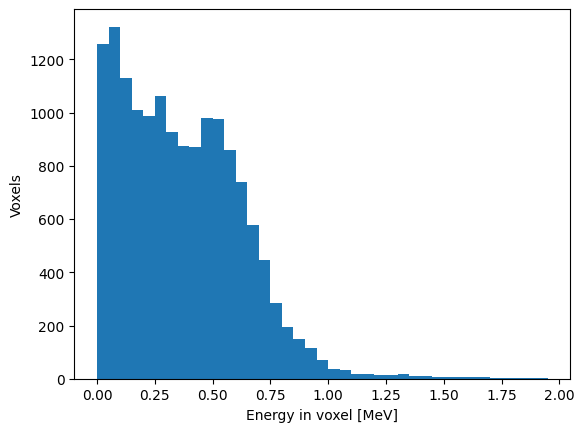

In [61]:
#SED point visualization
plt.hist(sed_nominal[:,VALUE_COL],bins=np.arange(0,2,0.05))
plt.xlabel('Energy in voxel [MeV]')
plt.ylabel('Voxels');

In [62]:
#Visualize energy depositions from various particles
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
sed_graph = tpc_traces
sed_graph += scatter_points(sed_nominal[:,COORD_COLS],sed_nominal[:,-1],colorscale='rainbow',markersize=1)
#sed_graph += scatter_points(event_nominal['sed'][:,COORD_COLS],event_nominal['sed'][:,VALUE_COL],colorscale='Inferno',markersize=1,cmax=1)
sed_graph[-1]['name'] = 'SED'

fig = go.Figure(sed_graph, layout=layout)
if make_plots:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_sed.png')

In [63]:
#Visualize shifted points
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
sed_shifted_graph = tpc_traces
#sed_shifted_graph += scatter_points(sed_shifted[:,COORD_COLS],sed_shifted[:,VALUE_COL],colorscale='Inferno',markersize=1,cmax=1)
sed_shifted_graph += scatter_points(sed_shifted[:,COORD_COLS],sed_shifted[:,-1],colorscale='rainbow',markersize=1)
sed_shifted_graph[-1]['name'] = 'SED shifted'

fig = go.Figure(sed_shifted_graph, layout=layout)
#if True:
if make_plots:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_sed_shifted.png')

### 3.4 SuperaSpacePoint

Stores reconstructed space points made by `Cluster3D`.

Example for SBND
```
SuperaSpacePoint: {
  Verbosity: 2
  SpacePointProducers: ["cluster3d"]
  OutputLabel:        "reco"
  DropOutput: ["hit_amp","hit_rms","hit_mult"]
  StoreWireInfo: true
  RecoChargeRange: [-1000, 50000]
}
```

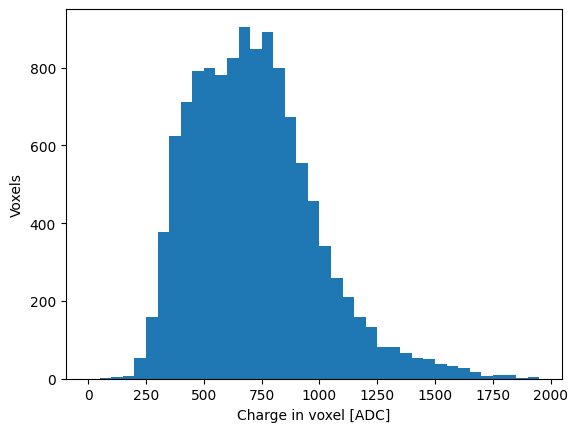

In [64]:
input_data = event_nominal['input_data'].tensor #Input space points
raw_charge = input_data[:, VALUE_COL] #Charge before pitch correction

plt.hist(raw_charge,bins=np.arange(0,2000,50))
plt.xlabel('Charge in voxel [ADC]')
plt.ylabel('Voxels');

In [65]:
#Cluster3D point visualization - why is colorscale not working??
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
graph = []
graph += tpc_traces

graph += scatter_points(input_data[:, COORD_COLS], color=raw_charge, colorscale='Inferno', cmax=500, markersize=1)
graph[-1]['name'] = 'Raw charge'

# graph += scatter_points(input_data[:, COORD_COLS], color=event_nominal['input_data'].tensor[:,5], colorscale='Inferno', cmax=10, markersize=1)
# graph[-1]['name'] = 'Chi2'

fig = go.Figure(graph, layout=layout)
#if True:
if make_plots:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_spacepoint.png')

In [66]:
#Make traces for bad and good parameters
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
traces = []
#traces += tpc_traces

traces += scatter_points(sed_nominal,opacity=0.4,color='green',markersize=1)
traces[-1].name = f'SED voxels'
traces += scatter_points(input_data,opacity=0.6,color='blue',markersize=1)
traces[-1].name = f'Cluster3D points'
# traces += scatter_points(event_bad_pix['input_data'][ghost_mask_bad],opacity=0.2,color='red',markersize=1)
# traces[-1].name = f'Cluster3D points (ghost)'

tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
traces_good = []
#traces_good += tpc_traces

traces_good += scatter_points(sed_shifted,opacity=0.4,color='green',markersize=1)
traces_good[-1].name = f'Shifted SED voxels'
traces_good += scatter_points(input_data,opacity=0.6,color='blue',markersize=1)
traces_good[-1].name = f'Cluster3D points'
# traces_good += scatter_points(event_nominal_pix['input_data'][ghost_mask],opacity=0.2,color='red',markersize=1)
# traces_good[-1].name = f'Cluster3D points (ghost)'

In [69]:
# Side-by-side event displays shifted and not shifted
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing=0.05, vertical_spacing=0.04)

fig.add_traces(traces, rows=len(traces) * [1], cols=len(traces) * [1])
fig.add_traces(traces_good, rows=len(traces_good) * [1], cols=len(traces_good) * [2])

#fig.layout = layout
fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=500,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20))
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_spacepoint_sed_comp.png')

### 3.5 SuperaMCParticleCluster

Assigns particle clusters for the particle and interaction for both GrapPA networks. It **heavily** relies on the `trackID` attribute being properly filled from a common source, usually Geant4. It also assigns the truth labels of reconstructed space points created in `Cluster3D`.

<div>
    <span style="font-size: 24px; font-weight: bold;">Data products for truth info</span>
</div>

- [SimChannel](https://internal.dunescience.org/doxygen/classsim_1_1SimChannel.html) - Contains the energy deposited per voxel and `trackID` of particle that deposited that energy. Filled from drift simulation.
- [MCParticle](https://internal.dunescience.org/doxygen/classsimb_1_1MCParticle.html) - Particles stored from Geant4 propagation. You will need to make sure secondary particles (i.e. from electromagnetic shower daughters) are also stored in the same list. 
- [SimEnergyDepositLite](https://sbnsoftware.github.io/doxygen/db/d64/SimEnergyDepositLite_8h.html) - Contains the energy deposited per voxel and `trackID` of particle that deposited that energy. From Geant4, *future Supera versions will replace this with SimChannel*.
- [MCTrack](https://github.com/LArSoft/lardataobj/blob/4dee2ea18f5d016ec0e65f7566a722cb37d081a2/lardataobj/MCBase/MCTrack.h) & [MCShower](https://github.com/LArSoft/lardataobj/blob/4dee2ea18f5d016ec0e65f7566a722cb37d081a2/lardataobj/MCBase/MCShower.h) - LArTPC specific particle objects used to track ancestory from primary. Contains `trackID` information about the the particle's mother and primary ancestor. 

<br>

**WARNING!!!** - "In house" particle propagation tools have a tendency to overwrite `trackID` with their own values so be careful that the trackIDs you're using is from the correct source. For example `SimChannel` has an attribute called `origTrackID` which contains the `trackID` from Geant4, which is the one you actually need!

<div>
    <span style="font-size: 24px; font-weight: bold;">Data products for reco info</span>
</div>



Example from SBND

```
SuperaMCParticleCluster: {
  OutputLabel: "pcluster"
  LArMCParticleProducer: "simplemerge" # produced when merging from previous stage
  LArMCShowerProducer: "mcreco"
  LArMCTrackProducer:  "mcreco"
  DeltaSize: 10
  LArSimEnergyDepositLiteProducer: "sedlite"
  Meta3DFromCluster3D: "mcst"
  Meta2DFromTensor2D:  ""
  Verbosity: 2
  UseSimEnergyDeposit: false #AnalyzeSimEnergyDeposit if true, else AnalyzeFirstLastStep - default false
  UseSimEnergyDepositLite: false 
  UseSimEnergyDepositPoints: false
  UseOrigTrackID: true #SUPER IMPORTANT
  CryostatList: [0,0]
  TPCList: [0,1]
  PlaneList: []
  SemanticPriority: [1,2,0,3,4] # 0-4 for shower track michel delta LE-scattering
  CheckParticleValidity: false #set false, but this needs to be checked later
  SuperaTrue2RecoVoxel3D: {
    UseOrigTrackID: true
    DebugMode: true
    Profile: true
    Verbosity: 2
    Meta3DFromCluster3D: "pcluster"
    LArSimChProducer: "simtpc2d simpleSC"
    LArSpacePointProducers: ["cluster3d"]
    OutputTensor3D:  "masked_true"
    OutputCluster3D: "masked_true2reco"
    TwofoldMatching: true
    UseTruePosition: true
    HitThresholdNe: 175
    HitWindowTicks: 5 #15
    HitPeakFinding: false
    PostAveraging: true
    PostAveragingThreshold_cm: 0.425
    DumpToCSV: false
            RecoChargeRange: [-1000,50000]
            VoxelDistanceThreshold: 1. #3
  }
}
```

In [17]:
#Cluster label
cluster_nominal = event_nominal['cluster_label'].tensor

In [18]:
#Visualization of labels
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
graph = scatter_particles(cluster_nominal,particles_nominal) #display all labels
graph += tpc_traces

fig = go.Figure(graph, layout=layout)
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_truth.png')

##### Example of SuperaTrue2RecoVoxel3D param search
Parameters to accept reco voxels. Applies threshold cuts based on following metrics - 
* `Hit number of electrons (Ne)` - Minimum number of electrons within tick window threshold
* `Tick window threshold (tw)` - Time window to accept Ne
* `Voxel distance threshold (vd)` - Conversion between tick window and drift velocity = tw/5
* `Post averaging threshold (pa)` - Lists associated reco voxels, splits true energy evenly between all of them, accepts reco voxels within radius of centroid of associated voxels

In [19]:
#Look at all files in parameter search
file_list = list(os.listdir(DATA_PATH))
sp_params = [extract_larcv_params(f) for f in file_list.copy()]
len(file_list)

448

##### **Matching voxels**
Use cKDTree to match voxels. cKDTree[1] spatially partitions recursively and stores points in a tree. Query returns $k$ nearest points (index from the array) and the distances to them. We can then specify the `matching threshold` to accept them as a match.

##### **Purity/Efficiency**
`Purity` describes how many reco voxels are within the matching threshold of a true voxel. `Efficiency` describes how many true voxels are within the matching threshold of a reco voxel.

`purity` =     `reco tagged` / `reco`

`efficiency` = `true tagged` / `true`

[1] https://ceur-ws.org/Vol-2786/Paper28.pdf

In [20]:
def reco_and_true_matching(reco_noghost,true,distance=0):
    """
    Calculates purtiy and efficiency by matching true voxel locations to reco voxel locations
    and vise-versa


    reco_noghost = xyz coords for nonghost
    true         = xyz for true parts
    distance     = threshold distance between voxels

    eff                 = true tagged voxel count / true voxel count
    pur                 = reco tagged voxel count / reco voxels (noghost)
    reco_tagged         = reco voxels that were matched to a true voxel (true->reco)
    true_tagged         = true voxels that were matched to a reco voxel (reco->true)
    reco_reverse_tagged = reco voxels that were matched to a true voxel (reco->true)
    """
    small = 1e-5 #offset for float precision
    tree = cKDTree(true) #Get tree to perform query
    #Return closest distance to each reco point, and indices of that voxel in the truth array
    distances, indices = tree.query(reco_noghost,k=1)
    reco_indices = []
    for i,d in enumerate(distances): #distances from nearest true voxel
        d-=small
        if d<=distance: #Ignore elements that don't satisfy distance threshold
            reco_indices.append(i)
    reco_tagged = reco_noghost[np.unique(reco_indices)]
    pur = len(reco_tagged)/len(reco_noghost)

    #Do it again for efficiency
    tree = cKDTree(reco_noghost) #Get tree to perform query
    #Return closest distance to each reco voxel, and indices of that voxel in the truth array
    distances, indices = tree.query(true,k=1) #Distance from reco to true voxels
    true_indices = []
    reco_tagged_indices = [] #additional index set to store reco points that were matched to true
    for i,d in enumerate(distances):
        d-=small
        if d<=distance: #Ignore elements that don't satisfy the criteria
            true_indices.append(i)
            reco_tagged_indices.append(indices[i])
    reco_reverse_tagged = reco_noghost[np.unique(reco_indices)] #Matched from truth voxel
    true_tagged = true[np.unique(true_indices)]
    eff = len(true_tagged)/len(true)

    return pur,eff,reco_tagged,true_indices,reco_tagged_indices,reco_reverse_tagged,reco_indices

In [21]:
#Compare a set of known bad parameter set and good parameter set
bad_params = {
    'ne': 200,    #number of electrons
    'tw': 5,      #tick window 
    'pa': 0.1,  #post averaging threshold (cm)
    'vd': 1       #voxel distance threshold = tw/5 (voxels)
}

bad_fname = get_larcv_fname(bad_params)
_cfg = yaml.safe_load(open(cfg, 'r').read().replace('FNAME', f'{DATA_PATH}/{bad_fname}')\
                      .replace('EVENT_ID',str(EVENT_ID))) #load event specified

# prepare function configures necessary "handlers"
driver = Driver(_cfg)

#Parse data
event_bad = driver.process()

# Load a specific event
event_bad_pix = copy.deepcopy(event_bad)

#Convert to detector coordinates
event_bad = prepare_event(event_bad)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfmilan105 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721835775}
io:
  loader:
    batch_size: 4
    shuffle: false
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: /sdf/data/neutrino/sbnd/simulation/mpvmpr_v01/spacepoint_params/larcv_ne200_pa100_tw5_vd1.root
      entry_list: [1]
      schema:
        input_data:
          parser: sparse3d
          args:
            sparse_event_list: [sparse3d_reco, sparse3d_reco_chi2, sparse3d_reco_hit_charge0,
              sparse3d_reco_hit_charge1, spar

In [22]:
#Find center of detector in voxels in x
meta = event_nominal['meta'][0]
lower_pix = meta.to_px(meta.lower)
upper_pix = meta.to_px(meta.upper)
xcenter_pix = (lower_pix[0]-upper_pix[0])/2+upper_pix[0]

#Get detector bounds in pixels
detector_pix = np.array([lower_pix,upper_pix])
detector_pix,xcenter_pix

(array([[   0.,    0.,    0.],
        [2048., 2048., 2048.]], dtype=float32),
 1024.0)

In [23]:
#Matching threshold
distance = np.sqrt(3) #Euclidean distance - voxels touching by a corner are considered matched

In [24]:
#Poorly tuned supera parameters
seg_label_bad = event_bad_pix['segment_label'].tensor[:,-1]
ghost_mask_bad = seg_label_bad == GHOST_SHP
reco_noghost_bad = event_bad_pix['input_data'].tensor[~ghost_mask_bad,1:4]
#shift points to match cluster3d
sed_bad = shift_sed_points(event_bad_pix['sed'].tensor,event_bad_pix['particles_asis'][0]
                           ,v=VDRIFT/.3 #convert vdrift units to pixel/us
                           #account for shifted cathode location
                           ,xcenter=xcenter_pix) 
#Now mask out all points that are not in the detector
_,mask = mask_out_unbounded(sed_bad[:,1:4],detector_pix)
sed_bad = sed_bad[mask] #apply detector mask

pur_bad,eff_bad,_,_,_,_,_ = reco_and_true_matching(reco_noghost_bad,sed_bad[:,1:4],distance=distance)

In [25]:
#SBND tuned supera parameters
seg_label_good = event_nominal_pix['segment_label'].tensor[:,-1]
ghost_mask = seg_label_good == GHOST_SHP
reco_noghost_good = event_nominal_pix['input_data'].tensor[~ghost_mask,1:4]
#shift points to match cluster3d
sed_good = shift_sed_points(event_nominal_pix['sed'].tensor,event_nominal_pix['particles_asis'][0]
                            ,v=VDRIFT/.3 #convert vdrift units to pixel/us
                            #account for shifted cathode location
                            ,xcenter=xcenter_pix) 
#Now mask out all points that are not in the detector
_,mask = mask_out_unbounded(sed_good[:,1:4],detector_pix)
sed_good = sed_good[mask] #apply detector mask

pur_good,eff_good,_,_,_,_,_ = reco_and_true_matching(reco_noghost_good,sed_good[:,1:4],distance=distance)

In [26]:
print(f'Purity and efficiency of nominal params: {pur_good:.3f}, {eff_good:.3f}')
print(f'Purity and efficiency of poorly tuned params: {pur_bad:.3f}, {eff_bad:.3f}')

Purity and efficiency of nominal params: 0.632, 0.582
Purity and efficiency of poorly tuned params: 0.708, 0.293


In [27]:
#Make traces for bad and good parameters
traces_bad = []

traces_bad += scatter_points(sed_bad,opacity=0.4,color='green',markersize=1)
traces_bad[-1].name = f'SED voxels'
traces_bad += scatter_points(event_bad_pix['input_data'].tensor[~ghost_mask_bad],opacity=0.6,color='blue',markersize=1)
traces_bad[-1].name = f'Cluster3D points (no ghost)'
# traces_bad += scatter_points(event_bad_pix['input_data'][ghost_mask_bad],opacity=0.2,color='red',markersize=1)
# traces_bad[-1].name = f'Cluster3D points (ghost)'

traces_good = []

traces_good += scatter_points(sed_good,opacity=0.4,color='green',markersize=1)
traces_good[-1].name = f'SED voxels'
traces_good += scatter_points(event_nominal_pix['input_data'].tensor[~ghost_mask],opacity=0.6,color='blue',markersize=1)
traces_good[-1].name = f'Cluster3D points (no ghost)'
# traces_good += scatter_points(event_nominal_pix['input_data'][ghost_mask],opacity=0.2,color='red',markersize=1)
# traces_good[-1].name = f'Cluster3D points (ghost)'

In [28]:
# Side-by-side event displays for sed vs. ghost
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing=0.05, vertical_spacing=0.04)

fig.add_traces(traces_bad, rows=len(traces_bad) * [1], cols=len(traces_bad) * [1])
fig.add_traces(traces_good, rows=len(traces_good) * [1], cols=len(traces_good) * [2])

fig.layout = layout3d()
fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=500,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20),
                 annotations=[
                dict(
                    text=f"Bad parameters {bad_params}",
                    x=0.,
                    y=1.05,
                    xref='paper',
                    yref='paper',
                    showarrow=False,
                    font=dict(size=12)
                ),
                dict(
                    text=f"Nominal parameters {sbnd_nominal_params}",
                    x=1.,
                    y=1.05,
                    xref='paper',
                    yref='paper',
                    showarrow=False,
                    font=dict(size=12)
                )])
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_spacepoint_label_comp.png')

**NOTE:** The efficiency is the more important number, since it displays how close a reco point is to a true point. However, you don't want to classify *too* many points as ghosts. If you do this, your purity metric will be low. So you want to maximize efficiency but leave the purity at a "reasonable" number.

##### **Gap Length / Track Completeness**
Investigate track completeness using third metric - gap length. This metric computes the gaps between clusters of reconstructed voxels belonging to the same cluster ID (use the true cluster ID).

* DBSCAN cluster voxels with Chebyshev metric ($\epsilon$ = 1.1)
* Order clusters along track using PCA
* Calculate intercluster distance $d_{i,i+1}$ between consecutive clusters
* $G=\sum_{i=0}^{n-1}(d_{i,i+1}-\delta)$ , $\delta=1/\textrm{max}_i|\vec{v}|$ where $\vec{v}$ is the track direction
* $\delta$ is meant to account for pixelized nature of voxels, i.e. traveling in just $\hat{z}$ you'd expect the distance to be 1 at maximum. Whereas if you're traveling $\frac{1}{\sqrt{3}} (\hat{x} + \hat{y}+ \hat{z})$ you'd expect the next point to be $\sqrt{3}$ from your point.
* Low $G/L$ indicates better track completeness

In [29]:
def match_input_cluster(clust_label,input_data,drop_duplicates=False,distance_threshold=0):
    """
    match cluster_label to input data using voxel coordinates
    distance_threshold matches voxels within threshold
    return input_data that matches clust_label
    """
    tree = cKDTree(input_data[:,1:4]) #Get tree to perform query
    #Return indices that are on top of the point
    distances, indices = tree.query(clust_label[:,1:4],k=1)
    ret_ind = []
    for d,i in zip(distances,indices):
        if d <= distance_threshold:
            ret_ind.append(i)
    input_data = input_data[ret_ind]
    return input_data
def track_length_calc(line_start,line_end):
    return np.linalg.norm(line_start-line_end)

In [30]:
def order_clusters(points, eps=1.1, min_samples=1):
    """
    Order clusters along the principal axis of the track.
    Args:
    points (numpy.ndarray): array of 3D points
    Returns:
    numpy.ndarray: array of ordered cluster indices
    """
    #DBSCAN with chebyshev clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='chebyshev').fit(points)
    labels = clustering.labels_
    unique_labels = np.unique(labels)
    centroids = np.array([points[labels == label].mean(axis=0) for label in unique_labels if label != -1])

    #PCA
    pca = PCA(n_components=2)
    pca.fit(points)
    projected_centroids = pca.transform(centroids)
    sorted_indices = np.argsort(projected_centroids[:, 0])

    return unique_labels[sorted_indices],labels

def inter_cluster_distance(points, labels, cluster_indices):
    """
    Compute inter-cluster distance between consecutive clusters.
    Args:
    points (numpy.ndarray): array of 3D points
    labels (numpy.ndarray): array of cluster labels
    cluster_indices (numpy.ndarray): array of ordered cluster indices
    Returns:
    List[float]: list of inter-cluster distances
    """
    distances = []

    for i in range(1, len(cluster_indices)):
        curr_cluster = points[labels == cluster_indices[i]]
        prev_cluster = points[labels == cluster_indices[i - 1]]
        min_dist = np.min(cdist(curr_cluster,prev_cluster))
        distances.append(min_dist)

    return distances

def gap_length_calc_cheb(points,start_point,end_point,norm_to_track_length=True,
                        eps=1.1, min_samples=1):
    """
    Computes chebyshev intercluster gap lengths, with option to normalize to total length
    Args:
        particle (analysis.classes.Particle): single particle
        norm_to_track_length (bool, optional): Divide gap length by track length. Defaults to True.
        eps (float, optional): DBSCAN epsilon distance parameter. Defaults to 1.1.
        min_samples (int, optional): Minimum number of clusters DBSCAN. Defaults to 1.
    Returns:
        float: gap length
    """
    #Get direction information
    direction = (start_point-end_point)/np.linalg.norm(start_point - end_point)
    gamma = 1/np.max(abs(direction))

    #Get cluster distances
    cluster_indices,labels = order_clusters(points,eps=eps, min_samples=min_samples)
    distances = inter_cluster_distance(points,labels,cluster_indices)
    g = np.sum(distances-gamma)
    if norm_to_track_length:
        g /= np.linalg.norm(start_point-end_point)
    return g

In [31]:
particle_label_nominal = event_nominal['particles_label'].tensor

#Find track pids
track_pids = []
for _pid in np.unique(particle_label_nominal[:,CLUST_COL]):
    mask = cluster_nominal[:,PART_COL] == _pid #get Cluster3D points
    mask_particle = particle_label_nominal[:,CLUST_COL] == _pid #Get particle that matched pid
    line = particle_label_nominal[mask_particle,1:4] #Start and end point of particle
    points = cluster_nominal[mask,1:4] #Cluster3D points for pid
    
    if line.shape == (2,3):# and len(points) > 50:
        #print(points)
        track_pids.append({'pid': _pid, 'points': len(points)})
track_pids

[{'pid': 0.0, 'points': 1487},
 {'pid': 1.0, 'points': 1820},
 {'pid': 2.0, 'points': 1516},
 {'pid': 3.0, 'points': 1693},
 {'pid': 4.0, 'points': 868},
 {'pid': 6.0, 'points': 373},
 {'pid': 7.0, 'points': 10},
 {'pid': 8.0, 'points': 270}]

In [32]:
cluster_nominal_pix = event_nominal_pix['cluster_label'].tensor
particle_label_nominal_pix = event_nominal_pix['particles_label'].tensor

#Params for gap length calc
pid = 0 #particle id
eps=1.1 #greater than 1 for float point precision
min_samples=1

#Get particle points
mask = cluster_nominal_pix[:,PART_COL] == pid #get Cluster3D points
mask_particle = particle_label_nominal_pix[:,CLUST_COL] == pid #Get particle that matched pid
line = particle_label_nominal_pix[mask_particle,1:4] #Start and end point of particle
points = cluster_nominal_pix[mask,1:4] #Cluster3D points for pid

#Calculate gap and track length
g = gap_length_calc_cheb(points,line[0],line[1],norm_to_track_length=False,
                        eps=eps, min_samples=min_samples)
track_length = track_length_calc(line[0],line[1])

In [33]:
#Display clustering for particle
clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='chebyshev').fit(points)

trace = []
trace+= scatter_points(points,markersize=2,
                       color=clustering.labels_,
                      colorscale='rainbow',
                       cmin=-1,
                      #mode = 'lines+markers',
                      )
trace[-1].name = f'Clustered Points (G/L = {g/track_length:.3f})'


trace += scatter_points(particle_label_nominal_pix[mask_particle],
                        markersize=8, 
                        color=particle_label_nominal_pix[mask_particle, 5])
trace[-1].name = trace[-1].name = f"True point labels (Length = {track_length_calc(line[0],line[1]):.1f} voxels)"

fig = go.Figure(data=trace,layout=layout3d())

fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=1000,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20),
                 title={
                   'text': f'{sbnd_nominal_params}','y':1,'x':0.5,
                 })
#if True:
if make_plots:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_clustering.png')

In [34]:
confirmation = input("WARNING: Do you want remake the performance dict (it will take about 10 minutes)? Type 'yes' to confirm: ")

if confirmation.lower() == 'yes':
    print("Cell running...")
    #Supress config printouts
    sys.stdout = open(os.devnull, 'w')

    performance_dicts = []

    for i,_fname in tqdm(enumerate(file_list)):
        # Get params from filename
        _params = extract_larcv_params(_fname)
        _cfg = yaml.safe_load(open(cfg, 'r').read().replace('FNAME', f'{DATA_PATH}/{_fname}')\
                              .replace('EVENT_ID',str(EVENT_ID))) #load event specified

        # prepare function configures necessary "handlers"
        driver = Driver(_cfg)

        #Parse data
        event = driver.process()

        #Convert to detector coordinates and save an event in pixels
        event_pix = copy.deepcopy(event)
        prepare_event(event)

        #Poorly tuned supera parameters
        seg_label = event_pix['segment_label'].tensor[:,-1]
        ghost_mask = seg_label == GHOST_SHP
        reco_noghost = event_pix['input_data'].tensor[~ghost_mask,1:4]
        #shift points to match cluster3d
        sed = shift_sed_points(event_pix['sed'].tensor,event_pix['particles_asis'][0]
                                   ,v=VDRIFT/.3 #convert vdrift units to pixel/us
                                   #account for shifted cathode location
                                   ,xcenter=xcenter_pix) 
        #Now mask out all points that are not in the detector
        _,mask = mask_out_unbounded(sed[:,1:4],detector_pix)
        sed = sed[mask] #apply detector mask

        pur,eff,_,_,_,_,_ = reco_and_true_matching(reco_noghost,sed[:,1:4],distance=distance)
        completeness_vec = []
        
        #Extract values
        particle_label = event['particles_label'].tensor
        cluster_pix = event_pix['cluster_label'].tensor
        cluster = event['cluster_label'].tensor
        particle_label_pix = event_pix['particles_label'].tensor
        

        #Compute completeness for all tracks
        for _pid in np.unique(particle_label[:,CLUST_COL]):
            _mask = cluster[:,PART_COL] == _pid #get Cluster3D points
            _mask_particle = particle_label[:,CLUST_COL] == _pid #Get particle that matched pid
            _line = particle_label[_mask_particle,1:4] #Start and end point of particle
            _points = cluster[_mask,1:4] #Cluster3D points for pid

            if _line.shape == (2,3):
                #Calculate gap and track length
                _g = gap_length_calc_cheb(_points,_line[0],_line[1],norm_to_track_length=False,
                                        eps=eps, min_samples=min_samples)
                _l = track_length_calc(_line[0],_line[1])
                completeness_vec.append(_g/_l)
        # {'ne': 150.0, 'pa': 0.55, 'tw': 10.0, 'vd': 2.0}
        if len(completeness_vec) == 0:
            avg_completeness = 1e5 #large dummy value
        else:
            avg_completeness = np.average(completeness_vec)
        performance_dicts.append({
            'ne':_params['ne'],
            'pa':_params['pa'],
            'tw':_params['tw'],
            'vd':_params['vd'],
            'pur':pur,
            'eff':eff,
            'completeness':avg_completeness
        })
    sys.stdout = orig_stdout
    with open(f'spacepoint_performance_eventid{EVENT_ID}.json', 'w') as file:
        json.dump(performance_dicts, file, indent=4)
else:
    with open(f'spacepoint_performance_eventid{EVENT_ID}.json', 'r') as file:
        performance_dicts = json.load(file)

len(performance_dicts)

448

In [35]:
performance_dicts[0]

{'ne': 150.0,
 'pa': 0.55,
 'tw': 10.0,
 'vd': 2.0,
 'pur': 0.617189763399324,
 'eff': 0.5931043645784894,
 'completeness': 0.35630066086835854}

In [36]:
def plot_pur_eff_hyperparams(purs,effs,nes,tws,vds,pat=None,**kwargs):
    """
    Plot pur, eff vs hyperparams
    """
    x = np.arange(len(purs)) #Get x values
    tick_labels = [''] #Store tick labels
    for i,ne in enumerate(nes):
        if pat is None:
            tick = fr'{ne:.0f} $N_e$ , {tws[i]} TW , {vds[i]} vd'
        else: 
            tick = fr'{ne:.0f} $N_e$ , {tws[i]} TW , {vds[i]} vd, {pat[i]:.3f} pa'
        tick_labels.append(tick)
    fig, ax = plt.subplots(figsize=(6,12))
    ax.plot(purs,x,color='red',label='Purity', **kwargs)
    ax.plot(effs,x,color='blue',label='Efficiency',**kwargs)
    #ax.plot(effs*purs,x,color='green',label=r'P$\times$E',**kwargs)
    #ax.axhline(np.argmax(effs),ls='--',color='black')
    ax.set_yticks(x)
    ax.set_yticklabels(tick_labels[1:],rotation=00)
    ax.legend()
    ax.set_xlabel('Pur/Eff')
    return fig,ax
def plot_metric_hyperparams(metric,label,nes,tws,vds,pat=None,**kwargs):
    """
    Plot pur, eff vs hyperparams
    """
    x = np.arange(len(metric)) #Get x values
    tick_labels = [''] #Store tick labels
    for i,ne in enumerate(nes):
        if pat is None:
            tick = fr'{ne} $N_e$ , {tws[i]} TW , {vds[i]} vd'
        else: 
            tick = fr'{ne} $N_e$ , {tws[i]} TW , {vds[i]} vd, {pat[i]:.3f} pa'
        tick_labels.append(tick)
    fig, ax = plt.subplots(figsize=(6,12))
    ax.plot(metric,x, **kwargs)
    ax.set_yticks(x)
    ax.set_yticklabels(tick_labels[1:],rotation=0)
    ax.set_xlabel(label)

    return fig,ax

In [37]:
#Extract into lists for plotting
distance = 3
nes = []
tws = []
vds = []
pas = []
purs = []
effs = []
gaps = []


for _dict in performance_dicts:
    nes.append(_dict['ne'])
    tws.append(_dict['tw'])
    vds.append(_dict['vd'])
    pas.append(_dict['pa'])
    purs.append(_dict['pur'])
    effs.append(_dict['eff'])
    gaps.append(_dict['completeness'])
        
#Convert to numpy
nes = np.array(nes)
tws = np.array(tws)
vds = np.array(vds)
pas = np.array(pas)
purs = np.array(purs)
effs = np.array(effs)
gaps = np.array(gaps)
pur_effs = purs*effs

#Sort by acsending efficiency and only look at the top 40
inds = np.argsort(effs)[-40:]
_nes = nes[inds]
_tws = tws[inds]
_vds = vds[inds]
_pas = pas[inds]
_purs = purs[inds]
_effs = effs[inds]
_gaps = gaps[inds]
_pur_effs = pur_effs[inds]

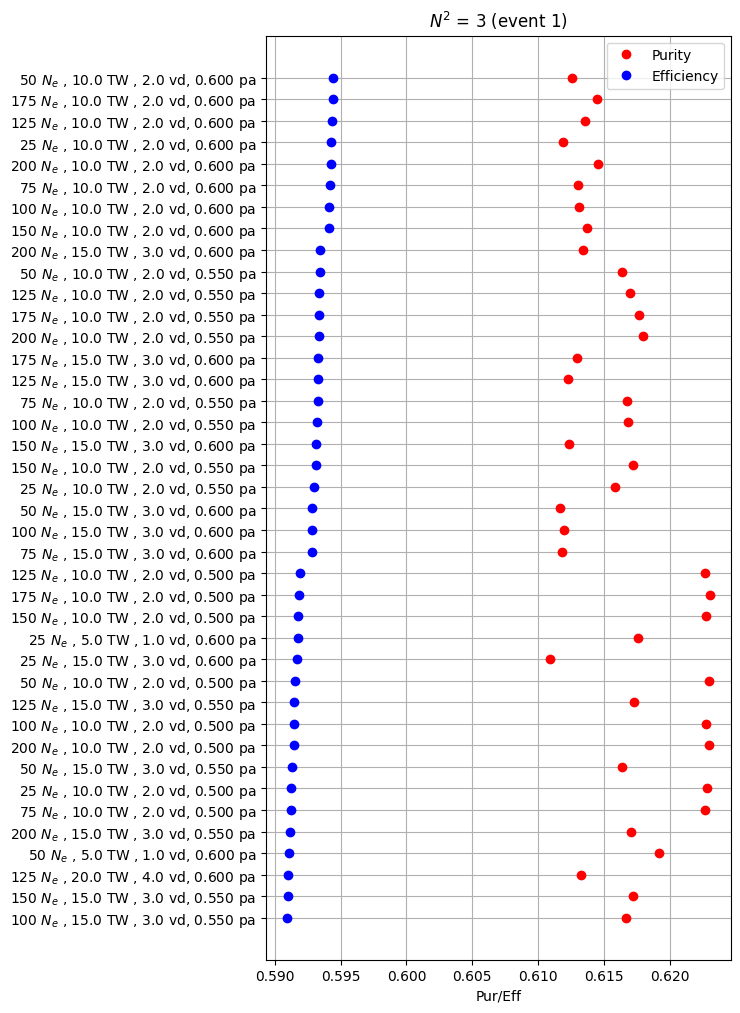

In [38]:
fig,ax = plot_pur_eff_hyperparams(_purs,_effs,_nes,_tws,_vds,_pas,marker='o',linestyle='')
ax.set_title(fr'$N^2$ = {distance} (event {EVENT_ID})')
ax.grid()
#ax.set_xlim([0,1])

In [39]:
#Sort by acsending completeness and only look at the top 40
#inds = np.argsort(-gaps)[-60:-20] #skip the first 20 or so inds since they are nan - clean up later
inds = np.argsort(-gaps)[-40:]
_nes = nes[inds]
_tws = tws[inds]
_vds = vds[inds]
_pas = pas[inds]
_purs = purs[inds]
_effs = effs[inds]
_gaps = gaps[inds]
_pur_effs = pur_effs[inds]

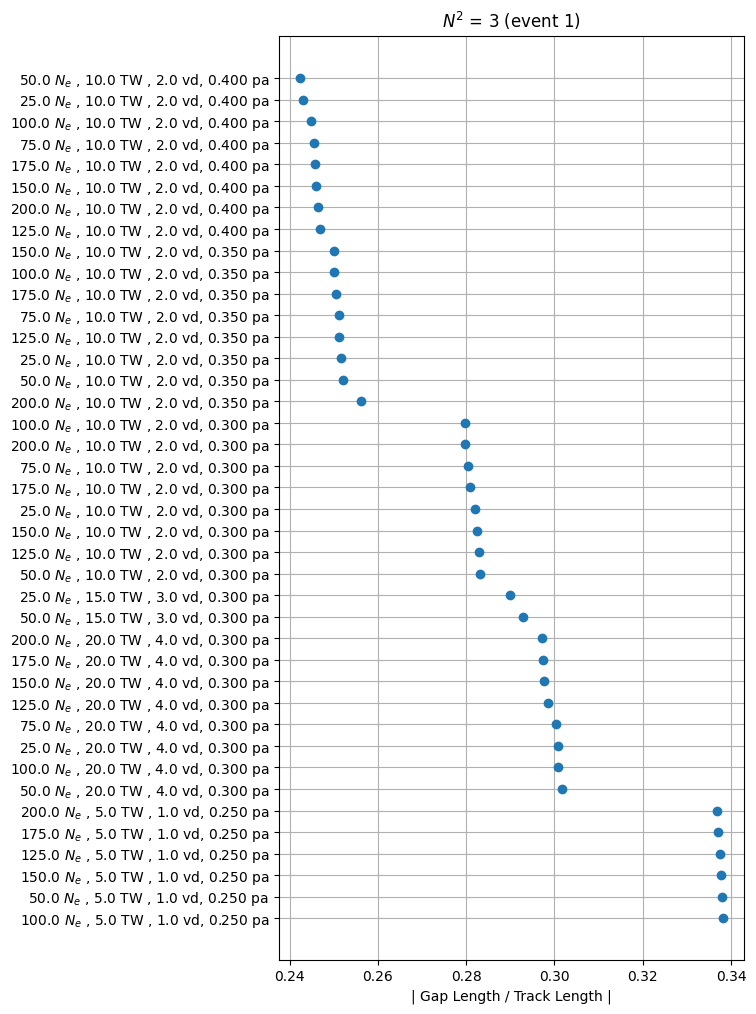

In [40]:
fig,ax = plot_metric_hyperparams(_gaps,'| Gap Length / Track Length |',_nes,_tws,_vds,_pas,marker='o',linestyle='')
ax.set_title(fr'$N^2$ = {distance} (event {EVENT_ID})')
ax.grid()
#ax.set_xlim([0,1])

##### **Interaction and particle clustering**
Points belonging to a common `trackID` belong to the same **particle**. Points belonging to a common ancestor's (progenetor of a particle and all of it's children) `trackID' belong to the same **interaction**.

### 3.6 SuperaOptical + SuperaCRT

Auxilary detector storage. Store optical flashes and CRT hits (not implemented in SBND) for now.

```
SuperaOptical: {
  OpFlashProducers: ["opflashtpc0xarapuca","opflashtpc1xarapuca","opflashtpc0","opflashtpc1"] #from SBND flash maker
  OpFlashOutputs: ["tpc0xa","tpc1xa","tpc0","tpc1"] #outputs to be used by flashmatcher
}
```

### 3.7 Tensor3D & Cluster3D



Labels individual pixels, mainly ghost vs. non-ghost. Also converts to larcv format.

- [Tensor3DFromCluster3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/Tensor3DFromCluster3D.h) - converts to larcv format
```
Tensor3DFromCluster3D: {
  Verbosity: 2
  Cluster3DProducerList: ["pcluster","sed"]
  OutputProducerList:    ["pcluster","sed"]
  PITypeList:  [1,1]
  FixedPIList: [0.,0.]
}
```
- [CombineTensor3DGhost](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/CombineTensor3D.h) - combines ghost and non-ghost voxels from Cluster3D
```
CombineTensor3DGhost: { # Combine voxels
  OutputProducer: "pcluster_semantics_ghost"
  Tensor3DProducers: ["reco"]
  PoolType: 0
}
```
- [ThresholdTensor3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/ThresholdTensor3D.h) - ???
```
ThresholdTensor3D: { # fill with ghost value (5)
  TargetProducer: "pcluster_semantics_ghost"
  OutputProducer: "pcluster_semantics_ghost"
  PaintValue: 5
}
```
- [CombineTensor3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/CombineTensor3D.h) - combines ghost labels with semantic labels
```
CombineTensor3D: {
  Tensor3DProducers: ["pcluster_semantics_ghost","pcluster_semantics"]
  OutputProducer:    "pcluster_semantics_ghost"
  PoolType: 0
}
```

In [47]:
#Show ghost vs. non-ghost
ghost_mask = event_nominal['segment_label'].tensor[:,-1]==GHOST_SHP

tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
graph = []
#graph += scatter_points(event_nominal['sed'][:,COORD_COLS], color=event_nominal['sed'][:,VALUE_COL], colorscale='Inferno', markersize=1)
#graph[-1]['name'] = 'SED'
graph += scatter_points(event_nominal['input_data'].tensor[ghost_mask], color='red', markersize=1)
graph[-1]['name'] = 'Ghosts'
graph += scatter_points(event_nominal['input_data'].tensor[~ghost_mask], color='blue', markersize=1)
graph[-1]['name'] = 'Non-ghosts'
graph += tpc_traces

fig = go.Figure(graph, layout=layout)
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_noghost.png')

In [48]:
#Show semantic + ppn labels
from matplotlib import colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

points_label = event_nominal['particles_label'].tensor[:, COORD_COLS]
#points_label = pixel_to_cm(points_label, event_nominal['meta'], True)
points_label_types = event_nominal['particles_label'].tensor[:, -3]
segment_label = event_nominal['cluster_label'].tensor[:,SHAPE_COL]

tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
graph = []
graph += scatter_points(event_nominal['cluster_label'].tensor, color=segment_label, cmin=0, cmax=4, markersize=1, colorscale=colors[:5])
graph[-1]['name'] = 'Semantic predictions'
graph += scatter_points(points_label, color=points_label_types, markersize=5, cmin=0, cmax=4, colorscale=colors[:5])
graph[-1]['name'] = 'PPN label points'

graph += tpc_traces

fig = go.Figure(graph, layout=layout)
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_ppn.png')

### 3.8 ParticleCorrector

Correct particle start/end point information based on `Cluster3D` info. 

### 3.9 RescaleChargeTensor3D

Plane pitch correction for raw charge output from `Cluster3D` space points. This accounts for using a single hit's charge for multiple space points. Used for wire readout LArTPCs.

<font size="5">$Q_\mu=\frac{1}{3}\sum_{p\in[0,1,2]}q_{p,\mu_p}/n_{p,\mu_p}$</font>

SBND example

```
RescaleChargeTensor3D: {
  HitKeyProducerList:    ["reco_hit_key0","reco_hit_key1","reco_hit_key2"]
  HitChargeProducerList: ["reco_hit_charge0","reco_hit_charge1","reco_hit_charge2"]
  OutputProducer:        "reco_rescaled"
  ReferenceProducer:     "pcluster"
}
```

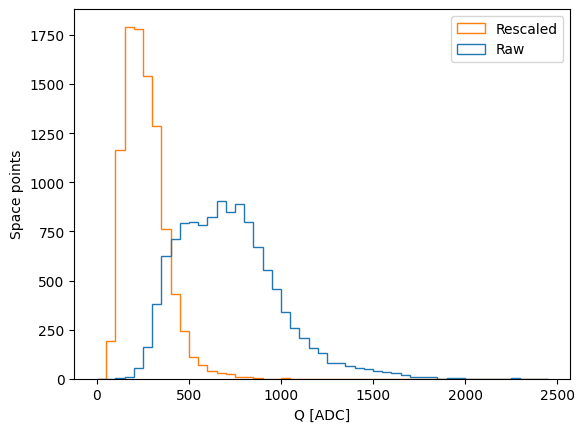

In [49]:
#ghost_mask = event_nominal['segment_label'][:,-1]==5

raw_charge = event_nominal['input_data'].tensor[:, VALUE_COL]
rescaled_charge = event_nominal['cluster_label'].tensor[:, VALUE_COL]

plt.hist([raw_charge,rescaled_charge],label=['Raw','Rescaled']
         ,histtype='step'
         ,bins=np.arange(0,2500,50))
plt.legend()
plt.xlabel('Q [ADC]')
plt.ylabel('Space points');

In [50]:
#Compare unscaled and rescaled charge - why is the colorscale not working??
trace_unscaled = []
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
trace_unscaled += scatter_points(event_nominal['input_data'].tensor[:, COORD_COLS], color=raw_charge, colorscale='Inferno', cmax=1500, markersize=1)
trace_unscaled[-1]['name'] = 'Raw charge'
# trace_unscaled += scatter_points(voxels_input, color=event['input_data'][:,5], colorscale='Inferno', cmax=10, markersize=1)
# trace_unsalced[-1]['name'] = 'Chi2'
trace_unscaled += tpc_traces

trace_rescaled = []
tpc_traces = detector_traces('sbnd', draw_faces=False, linewidth=5)
trace_rescaled += scatter_points(event_nominal['cluster_label'].tensor[:, COORD_COLS], color=rescaled_charge, colorscale='Inferno', cmax=500, markersize=1)
trace_rescaled[-1]['name'] = 'Rescaled charge'
trace_rescaled += tpc_traces

In [51]:
# Template cell for side-by-side event displays
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing=0.05, vertical_spacing=0.04)

fig.add_traces(trace_unscaled, rows=len(trace_unscaled) * [1], cols=len(trace_unscaled) * [1])
fig.add_traces(trace_rescaled, rows=len(trace_rescaled) * [1], cols=len(trace_rescaled) * [2])

fig.layout = layout3d()
fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=500,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20))
if make_plots:
#if True:
    iplot(fig)
if save_plots:
    fig.write_image('figures/event_sbnd_comp_raw_rescaled.png')

## 4. Instances of Supera failing

When Supera fails, it's usually due to `trackID` being misassigned. So it's not a Supera issue, but usually a `trackID` issue that occurs during simulation.

In [70]:
print('I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R \n'*100)

I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this sect